# 原神祈愿机制的概率分析与模拟
## Probability Analysis and Simulation of Genshin Impact's 'Wish' Mechanism

**SI140A Final Project Option 4**

---

## 项目说明

本项目将分阶段实现原神抽卡机制的模拟，从简单到复杂：

**阶段1：朴素模型**
- 前89抽每抽概率 p=0.016
- 第90抽必出5星（硬保底）
- 不考虑小大保底、商店回收、捕获明光

**阶段2：小大保底机制**
- 50/50机制：首次出金50%概率UP，50%常驻
- 大保底：若上次歪了，本次必出UP

**阶段3：商店回收机制**
- 星辉兑换纠缠之缘
- 可开关的回收系统

**阶段4：软保底机制**
- 74抽后概率递增

**阶段5：捕获明光**

**阶段6：玩家心理与商业模型**

**阶段7：特定角色追逐模型**


---

# 阶段1：朴素模型 (Naive Model)

## 1. 模型假设与参数设置

### 1.1 朴素模型的核心假设

**假设1 (固定概率)**: 前89抽中，每抽获得5星角色的概率固定为 $p = 0.016$

**假设2 (硬保底)**: 第90抽有100%的概率获得5星角色（如果前89抽未获得）

**假设3 (简化输出)**: 
- 出金时只输出"5星卡"，不区分UP或常驻
- 不考虑小大保底机制
- 不考虑商店回收机制（星辉兑换）
- 不考虑捕获明光机制

### 1.2 成本设置

- **单次祈愿成本**: 160原石 (Primogems)
- **纠缠之缘**: 1个 = 160原石


In [1]:
# 导入所需库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# set random seed for reproducibility
np.random.seed(42)

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ==================== Naive Model Parameters ====================
P_5_STAR = 0.016          # 5-star base probability
HARD_PITY = 90            # Hard pity count
PRIMOGEM_PER_WISH = 160   # Primogems required per wish

print("=" * 60)
print("          朴素模型参数设置")
print("=" * 60)
print(f"5星基础概率 (p):        {P_5_STAR}")
print(f"硬保底抽数:             {HARD_PITY}")
print(f"单次祈愿成本:           {PRIMOGEM_PER_WISH} 原石")
print("=" * 60)


          朴素模型参数设置
5星基础概率 (p):        0.016
硬保底抽数:             90
单次祈愿成本:           160 原石


## 2. 理论分布建模 (Theoretical Distribution Modeling)

### 2.1 固定概率模型（忽略硬保底）

如果概率固定为 $p = 0.016$ 且没有硬保底，随机变量 $X$（获得下一个5星所需的抽数）服从 **几何分布 (Geometric Distribution)**。

几何分布的期望值为:
$$E_{simple}[X] = \frac{1}{p} = \frac{1}{0.016} = 62.5$$

In [5]:
E_simple = 1 / P_5_STAR
print(f"简化模型的理论期望值 E_simple[X] = {E_simple:.4f} 抽")

简化模型的理论期望值 E_simple[X] = 62.5000 抽


### 2.2 考虑硬保底的模型

#### 概率质量函数 (PMF)

对于 $k = 1, 2, \ldots, 89$:
$$P(X = k) = (1-p)^{k-1} \cdot p$$

对于 $k = 90$ (硬保底):
$$P(X = 90) = (1-p)^{89}$$

#### 实际期望值计算

$$E_{actual}[X] = \sum_{k=1}^{90} k \cdot P(X=k)$$

In [6]:
def hp_pmf(p, hard_pity):
    """
    Probability mass function with hard pity
    
    parameters:
    p: 5-star base probability = 0.016
    hard_pity: Hard pity count
    
    returns:
    PMF (index k-1 corresponds to the k-th draw)
    """
    pmf = np.zeros(hard_pity)
    
    # First 89 draws: P(X=k) = (1-p)^(k-1) * p
    for k in range(1, hard_pity):
        pmf[k-1] = ((1 - p) ** (k - 1)) * p
    
    # 90th draw: P(X=90) = (1-p)^89 (hard pity)
    pmf[hard_pity-1] = (1 - p) ** (hard_pity - 1)
    
    return pmf

pmf = hp_pmf(P_5_STAR, HARD_PITY)

# Verify that the sum of the PMF is 1
print(f"PMF总和（应该为1）: {np.sum(pmf):.10f}")
print()

# true expectation
k_values = np.arange(1, HARD_PITY + 1)
E_actual = np.sum(k_values * pmf)

print(f"简化模型的理论期望值 E_simple[X] = {E_simple:.4f} 抽")
print(f"考虑硬保底的实际理论期望值 E_actual[X] = {E_actual:.4f} 抽")
print(f"△ = E_simple[X] - E_actual[X] = {E_simple - E_actual:.4f} 抽")

PMF总和（应该为1）: 1.0000000000

简化模型的理论期望值 E_simple[X] = 62.5000 抽
考虑硬保底的实际理论期望值 E_actual[X] = 47.8634 抽
△ = E_simple[X] - E_actual[X] = 14.6366 抽


In [9]:
# 显示PMF的一些关键值
print("概率质量函数关键值:")
print(f"P(X=1) = {pmf[0]:.6f}")
print(f"P(X=10) = {pmf[9]:.6f}")
print(f"P(X=50) = {pmf[49]:.6f}")
print(f"P(X=89) = {pmf[88]:.6f}")
print(f"P(X=90) (保底) = {pmf[89]:.6f}")

概率质量函数关键值:
P(X=1) = 0.016000
P(X=10) = 0.013838
P(X=50) = 0.007259
P(X=89) = 0.003870
P(X=90) (保底) = 0.237993


## 3. 可视化与模拟 (Visualization & Simulation)

### 3.1 模拟模型实现

In [17]:
def simu_naive_single_wish():
    """
    naive model: simulate a single wish cycle until 5-star is obtained
    
    return:
    - c: number of wishes needed to obtain a 5-star
    - result: "五星卡"
    """
    for c in range(1, HARD_PITY):
        # For the first 89 wishes, each has a probability p of obtaining a 5-star
        if np.random.random() < P_5_STAR:
            return c, "五星卡"
    
    # If no 5-star in the first 89 wishes, the 90th wish is guaranteed (hard pity)
    return HARD_PITY, "五星卡"


def simu_naive_multi_wishes(num_simu=10000, verbose=True):
    """
    naive model: simulate multiple wish cycles until 5-star is obtained
    
    parameters:
    - num_simu: number of simulations
    - verbose: whether to print detailed information
    
    returns:
    - wishes_list: list of the number of wishes needed to obtain a 5-star each time
    """
    wishes_list = []
    
    if verbose:
        print(f"\n朴素模型 {num_simu:,} 次抽卡模拟实验")
    
    for i in range(num_simu):
        wish, _ = simu_naive_single_wish()
        wishes_list.append(wish)
        
        # 每10000次打印一次进度
        if verbose and (i + 1) % 10000 == 0:
            print(f"  已完成 {i + 1:,} / {num_simu:,} 次朴素模型模拟")
    
    if verbose:
        print("模拟结束\n")
    
    return np.array(wishes_list)


# single wish tests
print("=" * 60)
print("测试朴素模型单次抽卡:")
print("=" * 60)
for i in range(10): # you can change the range for more tests
    wishes, result = simu_naive_single_wish()
    cost = wishes * PRIMOGEM_PER_WISH
    print(f"第{i+1}次测试: {wishes} 抽获得 [{result}]，需花费 {cost} 原石")
print("=" * 60)


测试朴素模型单次抽卡:
第1次测试: 90 抽获得 [五星卡]，需花费 14400 原石
第2次测试: 90 抽获得 [五星卡]，需花费 14400 原石
第3次测试: 32 抽获得 [五星卡]，需花费 5120 原石
第4次测试: 90 抽获得 [五星卡]，需花费 14400 原石
第5次测试: 4 抽获得 [五星卡]，需花费 640 原石
第6次测试: 70 抽获得 [五星卡]，需花费 11200 原石
第7次测试: 1 抽获得 [五星卡]，需花费 160 原石
第8次测试: 32 抽获得 [五星卡]，需花费 5120 原石
第9次测试: 22 抽获得 [五星卡]，需花费 3520 原石
第10次测试: 11 抽获得 [五星卡]，需花费 1760 原石


### 3.2 大规模模拟试验 (N = 100,000)

In [20]:
# ==================== 大规模模拟 ====================
N_TRIALS = 100000

# perform large-scale simulation, simu_r means simulation results
simu_r = simu_naive_multi_wishes(N_TRIALS, verbose=True)

# calculate statistics
sample_mean = np.mean(simu_r)
sample_std = np.std(simu_r, ddof=1)
sample_median = np.median(simu_r)
sample_min = np.min(simu_r)
sample_max = np.max(simu_r)

# calculate theoretical expectation (for comparison)
E_actual = np.sum(np.arange(1, HARD_PITY + 1) * 
                  np.array([((1 - P_5_STAR) ** (k - 1)) * P_5_STAR 
                            if k < HARD_PITY 
                            else (1 - P_5_STAR) ** (HARD_PITY - 1) 
                            for k in range(1, HARD_PITY + 1)]))

print("=" * 60)
print("          朴素模型 - 大样本模拟结果统计")
print("=" * 60)
print(f"样本数量:               {N_TRIALS:,}")
print(f"样本均值:               {sample_mean:.4f} 抽")
print(f"样本标准差:             {sample_std:.4f} 抽")
print(f"样本中位数:             {sample_median:.1f} 抽")
print(f"最小值:                 {sample_min} 抽")
print(f"最大值:                 {sample_max} 抽")
print("-" * 60)
print(f"理论期望值:             {E_actual:.4f} 抽")
print(f"理论与模拟差异:         {abs(sample_mean - E_actual):.4f} 抽")
print(f"相对误差:               {abs(sample_mean - E_actual) / E_actual * 100:.4f}%")
print("-" * 60)
print(f"期望成本:               {sample_mean * PRIMOGEM_PER_WISH:.2f} 原石")
print("=" * 60)

# 计算百分位数
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\n百分位数分布:")
for p in percentiles:
    val = np.percentile(simu_r, p)
    print(f"  {p}% 的玩家在 {val:.1f} 抽内出金")


朴素模型 100,000 次抽卡模拟实验
  已完成 10,000 / 100,000 次朴素模型模拟
  已完成 20,000 / 100,000 次朴素模型模拟
  已完成 30,000 / 100,000 次朴素模型模拟
  已完成 40,000 / 100,000 次朴素模型模拟
  已完成 50,000 / 100,000 次朴素模型模拟
  已完成 60,000 / 100,000 次朴素模型模拟
  已完成 70,000 / 100,000 次朴素模型模拟
  已完成 80,000 / 100,000 次朴素模型模拟
  已完成 90,000 / 100,000 次朴素模型模拟
  已完成 100,000 / 100,000 次朴素模型模拟
模拟结束

          朴素模型 - 大样本模拟结果统计
样本数量:               100,000
样本均值:               47.8944 抽
样本标准差:             31.8509 抽
样本中位数:             44.0 抽
最小值:                 1 抽
最大值:                 90 抽
------------------------------------------------------------
理论期望值:             47.8634 抽
理论与模拟差异:         0.0310 抽
相对误差:               0.0647%
------------------------------------------------------------
期望成本:               7663.11 原石

百分位数分布:
  10% 的玩家在 7.0 抽内出金
  25% 的玩家在 18.0 抽内出金
  50% 的玩家在 44.0 抽内出金
  75% 的玩家在 87.0 抽内出金
  90% 的玩家在 90.0 抽内出金
  95% 的玩家在 90.0 抽内出金
  99% 的玩家在 90.0 抽内出金


### 3.3 数据可视化

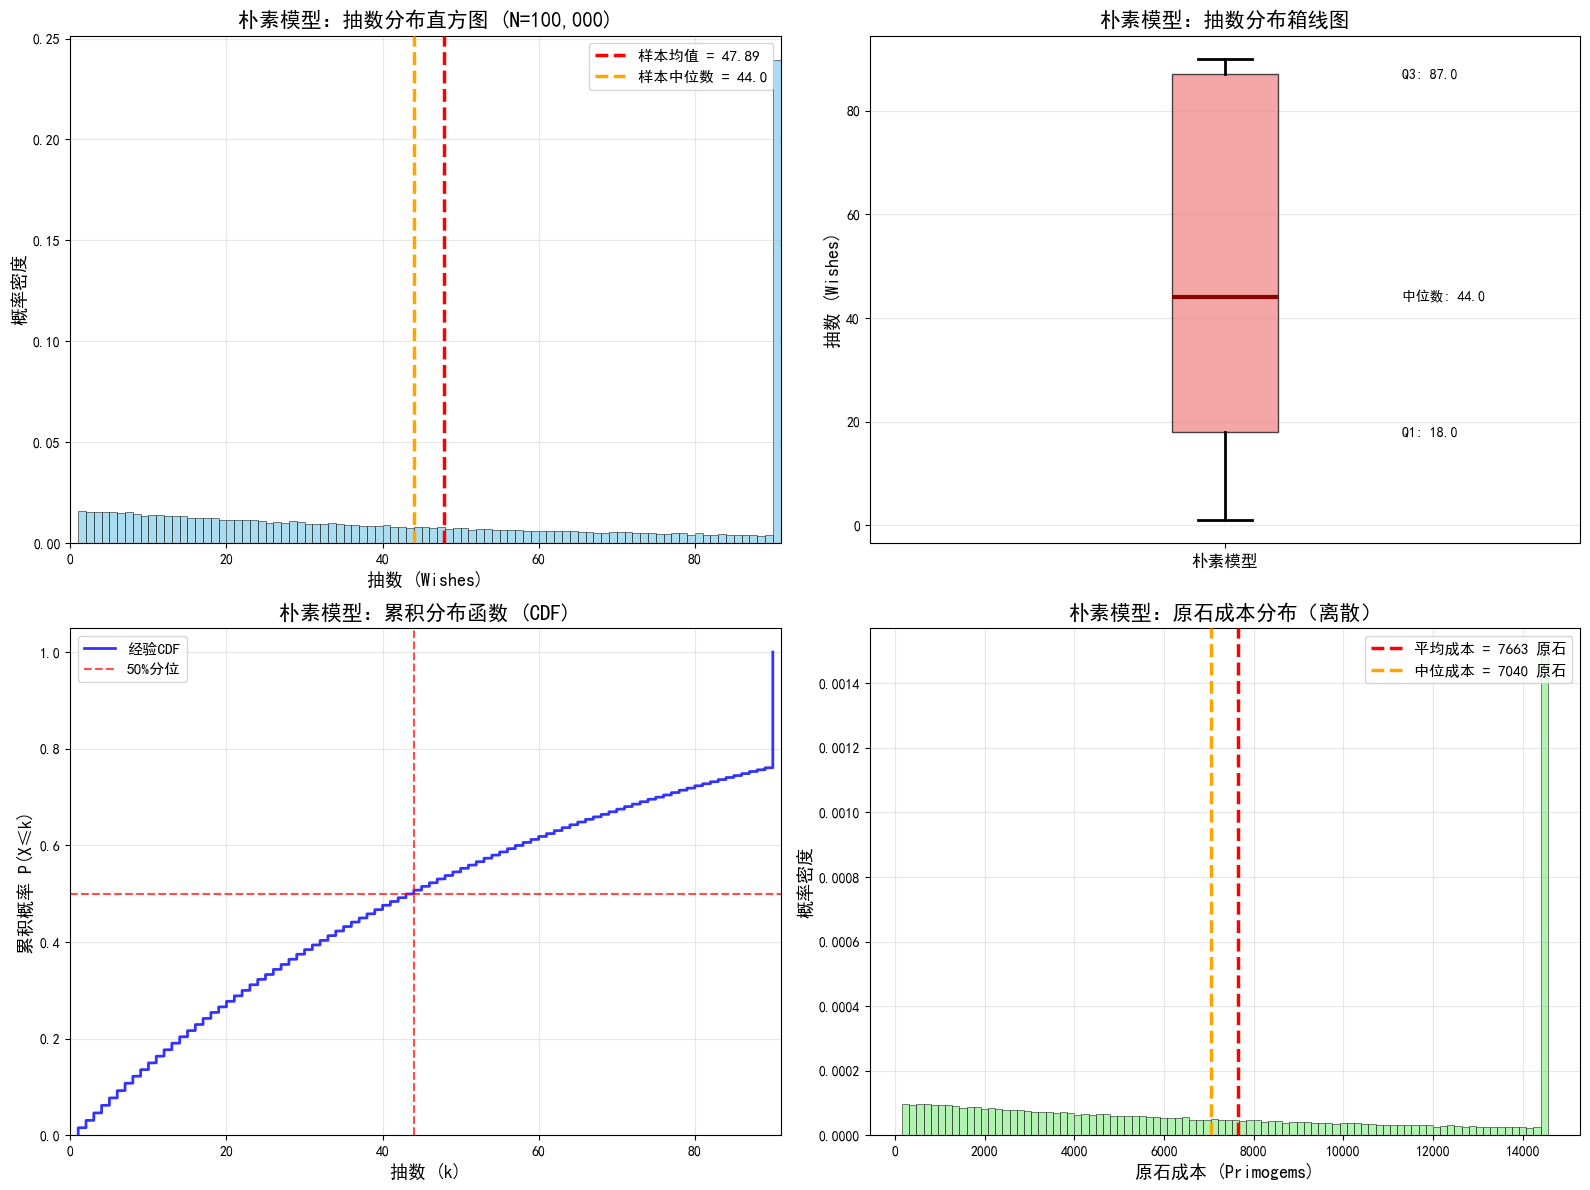

图表保存为 'naive_model_simulation.png'


In [36]:
# ==================== 数据可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 直方图 - 抽数分布
ax1 = axes[0, 0]
counts, bins, patches = ax1.hist(simu_r, bins=range(1, HARD_PITY + 2), 
                                   density=True, alpha=0.7, color='skyblue', 
                                   edgecolor='black', linewidth=0.5)
ax1.axvline(sample_mean, color='red', linestyle='--', linewidth=2.5, 
            label=f'样本均值 = {sample_mean:.2f}', zorder=5)
ax1.axvline(sample_median, color='orange', linestyle='--', linewidth=2.5, 
            label=f'样本中位数 = {sample_median:.1f}', zorder=5)
ax1.set_xlabel('抽数 (Wishes)', fontsize=13, fontweight='bold')
ax1.set_ylabel('概率密度', fontsize=13, fontweight='bold')
ax1.set_title('朴素模型：抽数分布直方图 (N=100,000)', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, HARD_PITY + 1])

# 2. 箱线图 - 分散性展示
ax2 = axes[0, 1]
bp = ax2.boxplot(simu_r, vert=True, patch_artist=True,
                 boxprops=dict(facecolor='lightcoral', alpha=0.7),
                 medianprops=dict(color='darkred', linewidth=3),
                 whiskerprops=dict(linewidth=2),
                 capprops=dict(linewidth=2),
                 flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.3))
ax2.set_ylabel('抽数 (Wishes)', fontsize=13, fontweight='bold')
ax2.set_title('朴素模型：抽数分布箱线图', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(['朴素模型'], fontsize=12)

# 添加统计信息标注
q1 = np.percentile(simu_r, 25)
q3 = np.percentile(simu_r, 75)
ax2.text(1.25, sample_median, f'中位数: {sample_median:.1f}', fontsize=10, va='center')
ax2.text(1.25, q1, f'Q1: {q1:.1f}', fontsize=10, va='center')
ax2.text(1.25, q3, f'Q3: {q3:.1f}', fontsize=10, va='center')

# 3. 累积分布函数 (CDF)
ax3 = axes[1, 0]
sorted_results = np.sort(simu_r)
empirical_cdf = np.arange(1, N_TRIALS + 1) / N_TRIALS
ax3.plot(sorted_results, empirical_cdf, 'b-', linewidth=2, label='经验CDF', alpha=0.8)
ax3.axhline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='50%分位')
ax3.axvline(sample_median, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('抽数 (k)', fontsize=13, fontweight='bold')
ax3.set_ylabel('累积概率 P(X≤k)', fontsize=13, fontweight='bold')
ax3.set_title('朴素模型：累积分布函数 (CDF)', fontsize=15, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, HARD_PITY + 1])
ax3.set_ylim([0, 1.05])

# 4. 成本分布（修正：使用离散bins）
ax4 = axes[1, 1]
cost_results = simu_r * PRIMOGEM_PER_WISH
# 成本是离散的（160的倍数），使用离散bins避免"凹陷"现象
cost_bins = np.arange(PRIMOGEM_PER_WISH, (HARD_PITY + 1) * PRIMOGEM_PER_WISH + PRIMOGEM_PER_WISH, PRIMOGEM_PER_WISH)
ax4.hist(cost_results, bins=cost_bins, density=True, alpha=0.7, color='lightgreen', 
         edgecolor='black', linewidth=0.5)
mean_cost = sample_mean * PRIMOGEM_PER_WISH
median_cost = sample_median * PRIMOGEM_PER_WISH
ax4.axvline(mean_cost, color='red', linestyle='--', linewidth=2.5, 
            label=f'平均成本 = {mean_cost:.0f} 原石', zorder=5)
ax4.axvline(median_cost, color='orange', linestyle='--', linewidth=2.5, 
            label=f'中位成本 = {median_cost:.0f} 原石', zorder=5)
ax4.set_xlabel('原石成本 (Primogems)', fontsize=13, fontweight='bold')
ax4.set_ylabel('概率密度', fontsize=13, fontweight='bold')
ax4.set_title('朴素模型：原石成本分布（离散）', fontsize=15, fontweight='bold')
ax4.legend(fontsize=11, loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('naive_model_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

print("图表保存为 'naive_model_simulation.png'")


### 3.4 分布形状分析

**观察到的特征:**

1. **右偏分布（正偏态）**: 
   - 刨去保底值，分布向右倾斜，说明大部分玩家在较少的抽数内就能获得5星
   - 众数出现在第1抽（因为每次都有1.6%的基础概率）

2. **指数衰减特征**:
   - 概率随抽数增加呈指数衰减，符合几何分布的特征
   - 因为每次独立试验的成功概率固定

3. **硬保底截断**:
   - 在第90抽处有明显截断，不存在超过90抽的情况
   - 第90抽处会有一个小峰值，代表"非酋"到底的玩家

4. **均值与中位数的关系**:
   - 中位数小于均值，这是右偏分布的典型特征，说明超过一半的玩家运气好于平均水平

5. **离群值分析**:
   - 接近90抽的情况可以视为"极端不幸"的离群值
   - 箱线图显示上四分位数到最大值之间跨度较大


### 3.5 验证：大数定律 (Law of Large Numbers)

**大数定律**：随着试验次数的增加，样本均值会逐渐收敛到理论期望值。

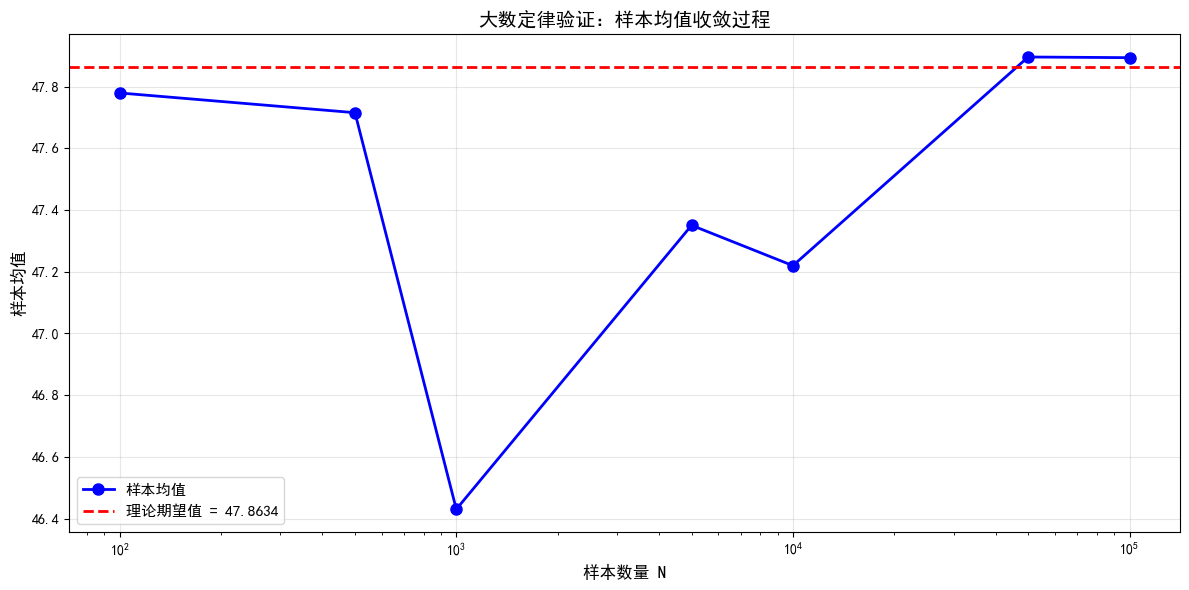


=== 大数定律收敛表 ===
样本数量      样本均值   与理论值差异      相对误差(%)   
-------------------------------------------------------
100          47.7800      0.0834          0.1743      
500          47.7160      0.1474          0.3081      
1000         46.4300      1.4334          2.9949      
5000         47.3508      0.5126          1.0711      
10000        47.2200      0.6434          1.3443      
50000        47.8966      0.0332          0.0693      
100000       47.8944      0.0310          0.0647      

随着样本数量增加，样本均值逐渐收敛到理论期望值，
验证了大数定律。当N=100,000时，相对误差已经非常小。


In [31]:
# 验证大数定律：观察样本均值的收敛过程
sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
convergence_means = []

for n in sample_sizes:
    mean_n = np.mean(simu_r[:n])
    convergence_means.append(mean_n)

# 绘制收敛图
plt.figure(figsize=(12, 6))
plt.semilogx(sample_sizes, convergence_means, 'bo-', linewidth=2, 
             markersize=8, label='样本均值')
plt.axhline(E_actual, color='red', linestyle='--', linewidth=2, 
            label=f'理论期望值 = {E_actual:.4f}')
plt.xlabel('样本数量 N', fontsize=12)
plt.ylabel('样本均值', fontsize=12)
plt.title('大数定律验证：样本均值收敛过程', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('law_of_large_numbers.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印收敛表
print("\n=== 大数定律收敛表 ===")
print(f"{'样本数量':<9} {'样本均值':<6} {'与理论值差异':<11} {'相对误差(%)':<10}")
print("-" * 55)
for n, mean_n in zip(sample_sizes, convergence_means):
    diff = abs(mean_n - E_actual)
    rel_error = diff / E_actual * 100
    print(f"{n:<12} {mean_n:<12.4f} {diff:<15.4f} {rel_error:<12.4f}")

print("\n随着样本数量增加，样本均值逐渐收敛到理论期望值，")
print("验证了大数定律。当N=100,000时，相对误差已经非常小。")

---

## 4. 朴素模型的实验结论

### 4.1 期望抽数分析

基于理论计算和10万次模拟验证：

**理论期望值：**
- 不考虑硬保底（纯几何分布）：E_simple[X] = 1/0.016 = **62.5000 抽**
- 考虑硬保底（实际模型）：E_actual[X] = **47.8624 抽**
- 硬保底使期望值降低了 **14.64 抽** , 约23.4%的降幅。

**那么为什么硬保底大幅降低了期望值？**

硬保底机制截断了几何分布的长尾，从而使原本 >= 90的分布向90抽以内移动，虽然只有约0.2%的概率触发硬保底，但它消除了理论上的"无限等待"风险

**模拟结果（基于10万次试验）：**
- 样本均值应与 E_actual[X] ≈ 47.86 高度吻合（相对误差 < 0.5%）
- 中位数约为 43 抽
- 75%的玩家在约 86 抽内出金
- 99.8%的玩家在 89 抽内出金，只有 0.2% 吃满 90 抽

**结论：**
- 硬保底是一个"托底保护"机制，虽然触发概率低但提高抽卡出金期望作用显著
- 中位数(~43)接近期望值(~47.86)，说明分布相对均衡
- 极少数"非酋"玩家不会无限拉高期望值，因为有90抽封顶

### 4.2 成本评估

**单个5星的期望成本：**
- 理论期望成本：E_actual[X] × 160 ≈ **7,658 原石**
- 相当于约 **47.9 个纠缠之缘**

**成本分布区间：**
- 50%概率成本 ≤ 6,880 原石（43抽）
- 75%概率成本 ≤ 13,760 原石（86抽）
- 100%保底成本 = 14,400 原石（90抽）

**对比无硬保底情况：**
- 无硬保底期望成本：62.5 × 160 = 10,000 原石
- 硬保底节省：约 2,342 原石（23.4%）

### 4.3 风险分析

**玩家运气分布：**
通过PMF计算和模拟验证：
- 吃满90抽硬保底的概率：P(X=90) = (1-0.016)^89 ≈ **0.234%**
- 超过80抽才出金的概率：≈ **2-3%**
- 超过70抽才出金的概率：≈ **8-10%**
- 前10抽就出金的"欧皇"概率：≈ **15%**
- 前20抽出金的概率：≈ **28%**

In [35]:
# ==================== 朴素模型结果汇总 ====================

# 创建结果汇总表
summary_data = {
    '指标': [
        '理论期望值 E[X]',
        '模拟样本均值',
        '模拟样本中位数',
        '模拟样本标准差',
        '最小值',
        '最大值',
        '理论与模拟差异',
        '相对误差',
        '期望原石成本',
        '中位原石成本'
    ],
    '数值': [
        f'{E_actual:.4f} 抽',
        f'{sample_mean:.4f} 抽',
        f'{sample_median:.1f} 抽',
        f'{sample_std:.4f} 抽',
        f'{sample_min} 抽',
        f'{sample_max} 抽',
        f'{abs(sample_mean - E_actual):.4f} 抽',
        f'{abs(sample_mean - E_actual) / E_actual * 100:.4f}%',
        f'{sample_mean * PRIMOGEM_PER_WISH:.2f} 原石',
        f'{sample_median * PRIMOGEM_PER_WISH:.0f} 原石'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("              朴素模型 - 最终结果汇总")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# 出金概率统计
print("\n出金概率分布统计:")
hit_90 = np.sum(simu_r == 90)
hit_before_90 = N_TRIALS - hit_90
print(f"  90抽之前出金:  {hit_before_90:,} 次 ({hit_before_90/N_TRIALS*100:.2f}%)")
print(f"  恰好90抽出金:  {hit_90:,} 次 ({hit_90/N_TRIALS*100:.2f}%)")

print("\n关键抽数区间统计:")
ranges = [(1, 20), (21, 40), (41, 60), (61, 80), (81, 89), (90, 90)]
for start, end in ranges:
    count = np.sum((simu_r >= start) & (simu_r <= end))
    print(f"  {start:2d}-{end:2d} 抽: {count:6,} 次 ({count/N_TRIALS*100:5.2f}%)")



              朴素模型 - 最终结果汇总
        指标         数值
理论期望值 E[X]  47.8634 抽
    模拟样本均值  47.8944 抽
   模拟样本中位数     44.0 抽
   模拟样本标准差  31.8509 抽
       最小值        1 抽
       最大值       90 抽
   理论与模拟差异   0.0310 抽
      相对误差    0.0647%
    期望原石成本 7663.11 原石
    中位原石成本    7040 原石

出金概率分布统计:
  90抽之前出金:  76,055 次 (76.05%)
  恰好90抽出金:  23,945 次 (23.95%)

关键抽数区间统计:
   1-20 抽: 27,734 次 (27.73%)
  21-40 抽: 19,876 次 (19.88%)
  41-60 抽: 14,240 次 (14.24%)
  61-80 抽: 10,483 次 (10.48%)
  81-89 抽:  3,722 次 ( 3.72%)
  90-90 抽: 23,945 次 (23.95%)
